In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

In [3]:
# TODO: Update here!
def exact_solutions_expressions(mesh):
    x, y = fd.SpatialCoordinate(mesh)
    p_exact = fd.sin(2 * fd.pi * x) * fd.sin(2 * fd.pi * y)  # noqa: F405
    flux_exact = -grad(p_exact)
    return p_exact, flux_exact


def calculate_exact_solution(
    mesh, pressure_family, velocity_family, pressure_degree, velocity_degree, is_hdiv_space=False
):
    """
    For compatibility only. Should be removed.
    """
    return exact_solutions_expressions(mesh)

## Exact solutions

In [4]:
# 1) Create a mesh and function‐spaces.  For example, a unit square:
mesh = fd.UnitSquareMesh(10, 10)

# Vector‐valued H1 space for velocity, and scalar CG1 space for pressure:
V = fd.VectorFunctionSpace(mesh, "CG", 1)
Q = fd.FunctionSpace(mesh, "CG", 1)

# 2) Declare SpatialCoordinate and all parameters:
x, y = fd.SpatialCoordinate(mesh)

# Physical / problem parameters (you can change these as needed):
k1 = fd.Constant(1.0)  # example value for k1
k2 = fd.Constant(0.1)  # example value for k2
beta = fd.Constant(1.0)  # example value for β
mu = fd.Constant(1.0)  # example value for μ

# Define η = sqrt(β (k1 + k2) / (k1 k2))
eta = fd.sqrt(beta * (k1 + k2) / (k1 * k2))

# 3) Build the UFL expressions for u1, p1, u2, p2 exactly as given:
u1_expr = fd.as_vector(
    [
        -k1 * (exp(pi * x) * sin(pi * y)),
        -k1 * (exp(pi * x) * cos(pi * y) - (eta / (beta * k1)) * exp(eta * y)),
    ]
)

p1_expr = (mu / pi) * exp(pi * x) * sin(pi * y) - (mu / (beta * k1)) * exp(eta * y)

u2_expr = fd.as_vector(
    [
        -k2 * (exp(pi * x) * sin(pi * y)),
        -k2 * (exp(pi * x) * cos(pi * y) + (eta / (beta * k2)) * exp(eta * y)),
    ]
)

p2_expr = (mu / pi) * exp(pi * x) * sin(pi * y) + (mu / (beta * k2)) * exp(eta * y)

# 4) Now interpolate each analytic expression into a Firedrake Function:
u1_exact = fd.Function(V, name="u1_analytic")
u1_exact.interpolate(u1_expr)

p1_exact = fd.Function(Q, name="p1_analytic")
p1_exact.interpolate(p1_expr)

u2_exact = fd.Function(V, name="u2_analytic")
u2_exact.interpolate(u2_expr)

p2_exact = fd.Function(Q, name="p2_analytic")
p2_exact.interpolate(p2_expr)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x76a8105fb8e0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 15)

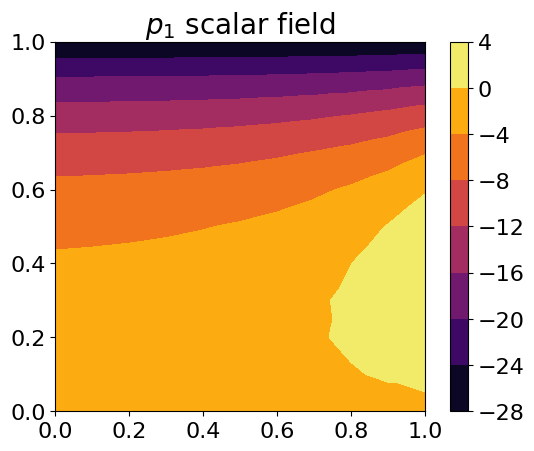

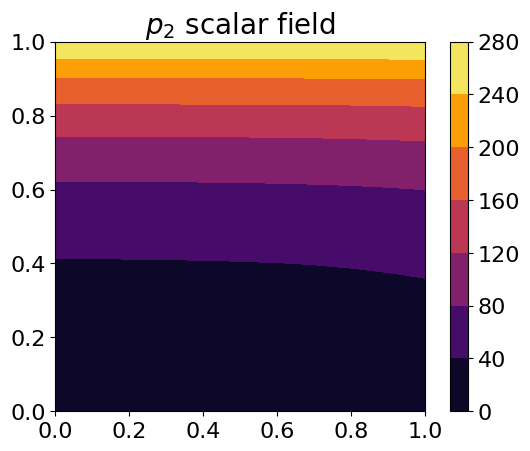

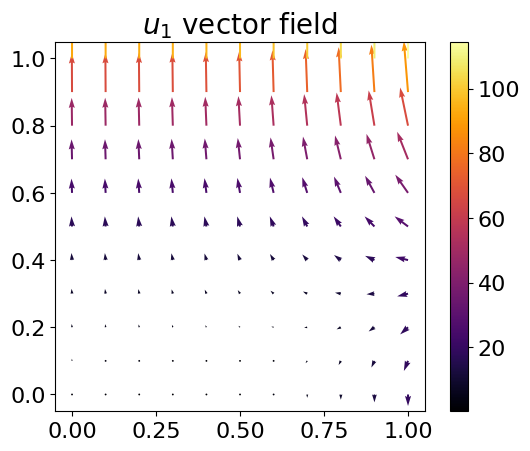

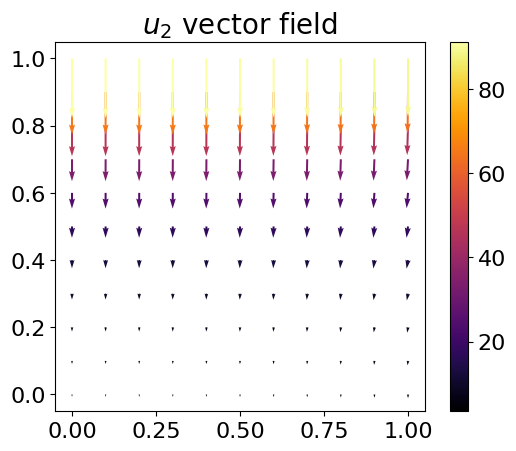

In [5]:
fig, axes = plt.subplots()
contours = fd.tricontourf(p1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_1$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.tricontourf(p2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$p_2$ scalar field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u1_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_1$ vector field")
fig.colorbar(contours)
plt.show()

fig, axes = plt.subplots()
contours = fd.quiver(u2_exact, axes=axes, cmap="inferno")
axes.set_aspect("equal")
axes.set_title(r"$u_2$ vector field")
fig.colorbar(contours)
plt.show()

## Conforming Galerkin FEM approximations

### Monolithic (fully coupled) approximation

In [6]:
num_elements_x, num_elements_y = 10, 10
enable_run_on_quads = False
mesh = fd.UnitSquareMesh(
    num_elements_x,
    num_elements_y,
    quadrilateral=enable_run_on_quads,
)

# Approximation
degree = 1

# Function space declaration
pressure_family = "CG"
velocity_family = "CG"
U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
V = fd.FunctionSpace(mesh, pressure_family, degree)

# Trial and test functions
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

# Exact solution
exact_solution, sigma_e = calculate_exact_solution(
    mesh, pressure_family, velocity_family, degree + 3, degree + 3
)

# Forcing function
f = fd.Constant(0.0)

# Dirichlet BCs
bcs = fd.DirichletBC(V, fd.project(exact_solution, V), "on_boundary")

# Variational form
a = inner(grad(u), grad(v)) * dx
L = f * v * dx

# Solving the problem
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
solution = fd.Function(V)
problem = fd.LinearVariationalProblem(a, L, solution, bcs=bcs, constant_jacobian=False)
solver = fd.LinearVariationalSolver(problem, solver_parameters=solver_parameters)
solver.solve()

# Retrieving the solution
p_h = solution
sigma_h = fd.project(-grad(p_h), U)